# **Text Mining - Grupo 27: Caroline Dalcomuni de Moura, Carolina Martins Rosa**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report, accuracy_score
from nltk.tokenize import word_tokenize
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import cross_val_score, KFold
from textblob import TextBlob
from sklearn.svm import SVC
import time

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

path_to_resources = 'resources/'

train = pd.read_csv(path_to_resources + "amazon_reviews_train.csv")
test = pd.read_csv(path_to_resources + "amazon_reviews_test.csv")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/carolinemoura/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/carolinemoura/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/carolinemoura/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/carolinemoura/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


**1.1 Dados**

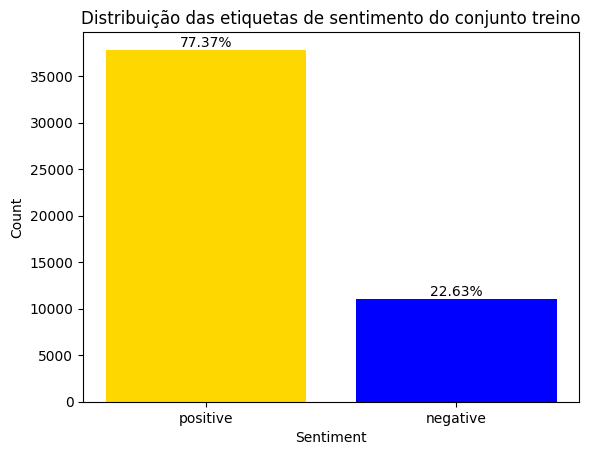

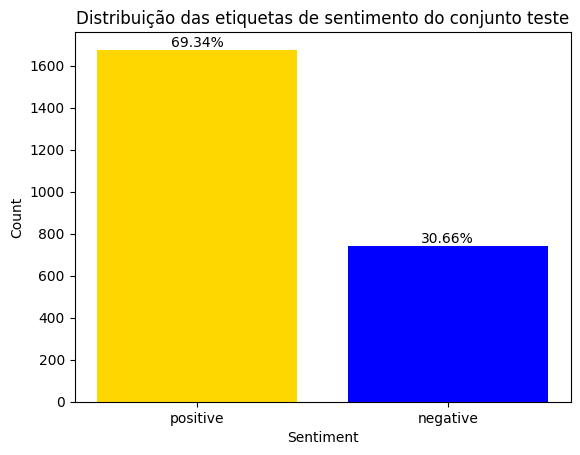

In [3]:
# Análise Exploratória dos Dados
def plot_sentiment_distribution(data, title):
    sentiment_counts = data['sentiment'].value_counts()
    labels = sentiment_counts.index.tolist()
    counts = sentiment_counts.values.tolist()

    total = sum(counts)
    percentages = [(count/total)*100 for count in counts]

    plt.figure()
    bars = plt.bar(labels, counts, color=['#FFD700', '#0000FF'])
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.title(title)

    for bar, percentage in zip(bars, percentages):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percentage:.2f}%',
                 ha='center', va='bottom')

    plt.show()

plot_sentiment_distribution(train, 'Distribuição das etiquetas de sentimento do conjunto treino')
plot_sentiment_distribution(test, 'Distribuição das etiquetas de sentimento do conjunto teste')

In [4]:
reviews_teste=test["review"].tolist()
sentimento_teste=test["sentiment"].tolist()

reviews_treino=train["review"].tolist()
sentimento_treino=train["sentiment"].tolist()

print(f"Total de reviews:{len(reviews_treino)+len(reviews_teste)}")
print("Percentagem do conjunto de treino: {:.3f}".format(len(reviews_treino)/(len(reviews_treino)+len(reviews_teste))*100))

Total de reviews:51319
Percentagem do conjunto de treino: 95.290


**1.2 Definição de um baseline usando ferramentas já existentes**

In [5]:
def sentiment_label(score):
    if score > 0:
        return 'positive'
    else:
        return 'negative'
    
def add_to_confusion_matrix(confusion_matrix, true_sentiment, predicted_sentiment):
    if true_sentiment == "positive":
        if true_sentiment == predicted_sentiment:
            confusion_matrix["TP"] += 1
        else:
            confusion_matrix["FN"] += 1
    else:
        if true_sentiment == predicted_sentiment:
            confusion_matrix["TN"] += 1
        else:
            confusion_matrix["FP"] += 1
            
def get_metrics(confusion_matrix):
    accuracy = round((confusion_matrix["TP"] + confusion_matrix["TN"]) / (confusion_matrix["TP"] + confusion_matrix["FN"] + confusion_matrix["FP"] + confusion_matrix["TN"]), 4)
    precision = round((confusion_matrix["TP"]) / (confusion_matrix["TP"] + confusion_matrix["FP"]), 4)
    recall = round((confusion_matrix["TP"]) / (confusion_matrix["TP"] + confusion_matrix["FN"]), 4)
    f1 = round((2 * precision * recall) / (precision + recall),4)
    return accuracy, precision, recall, f1


**TextBlob**

In [6]:
def textblob_metrics(reviews, labels):
    confusion_matrix = {"TP" : 0, "FN" : 0, "FP" : 0, "TN" : 0}
    results = {}
    start_time = time.time()
    for i in range(len(reviews)):
        review = reviews[i]
        true_sentiment = labels[i]
        score = round(TextBlob(review).sentiment.polarity, 3)
        predicted_sentiment = sentiment_label(score)
        add_to_confusion_matrix(confusion_matrix, true_sentiment, predicted_sentiment)
    accuracy, precision, recall, f1 = get_metrics(confusion_matrix)
    results["textblob_metrics"] = [accuracy, precision, recall, f1,round(((time.time()-start_time) / 60),2)]
    return pd.DataFrame.from_dict(results, orient='index',columns=["Accuracy","Precision","Recall","F1","Time"])

textblob_metrics_result = textblob_metrics(reviews_teste, sentimento_teste)
print(textblob_metrics_result)

                  Accuracy  Precision  Recall      F1  Time
textblob_metrics    0.7691     0.7778  0.9338  0.8487  0.01


**Vader Sentiment**

In [7]:
# Baseline Metrics using Vader Sentiment

sa = SentimentIntensityAnalyzer()

texts = test['review'].tolist()
for text in texts:
    scores = sa.polarity_scores(text)
    print('Review:', text)
    print('Positive:', scores['pos'])
    print('Negative:', scores['neg'])
    print('Compound Sentiment Score:', scores['compound'])
    print()
df = pd.read_csv(path_to_resources + 'amazon_reviews_test.csv')

# Predict sentiments
df['predicted_label'] = df['review'].apply(lambda x: sentiment_label(sa.polarity_scores(x)['compound']))

# Calculate and print classification report and accuracy
print(classification_report(df['sentiment'], df['predicted_label']))
accuracy = accuracy_score(df['sentiment'], df['predicted_label'])
print('Accuracy:', accuracy)

Review: I was going to give these seeds a 3-star rating until I realized, they're not good enough to order again. I'm sure I don't want them again so I'm closer to "I don't like" than "OK".<br /><br />The good:<br />The salt content IS pretty good. On par with how we season our own.<br />They're crisp.<br /><br />The bad:<br />Seeds are pretty small which means the ratio between seed and shell is not great.<br />Small seeds means you almost can't shell them, you HAVE to eat the shells.<br />Too many seeds have a sour taste which ruins the hole experience.<br />Per ounce they're more expensive than any others I've tried.<br /><br />I wish David's Seeds put out a lighter sea salt version. Their seeds are much larger so you can peel the shells if you want. They just have too much salt. I remember eating the Indian brand when I was a kid. They had a great tasting seed but unfortunately even more salt than Davids.
Positive: 0.076
Negative: 0.054
Compound Sentiment Score: 0.4462

Review: Thi

In [8]:
def print_metrics(metrics, model_name):
    accuracy, precision, recall, f1 = metrics
    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

**1.3 Preparação de dados e aplicação de um léxico de sentimentos**

**NEGATION HANDLING**

In [9]:
# Text Processing

def preprocess_text1(text, lower=True, remove_stopwords=True, handle_negation=True):
    # Lowercasing
    if lower:
        text = text.lower()

    # Tokenization 
    tokens_neg = word_tokenize(text)

    # Removing stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words("english"))
        tokens_neg = [word for word in tokens_neg if word not in stop_words]

    # Negation
    if handle_negation:
        negation_words = ["not", "no", "never", "none", "neither", "nor", "didn't like", "did not", "hate"]
        negated = False
        for i in range(len(tokens_neg)):
            if tokens_neg[i] in negation_words:
                negated = not negated
            elif negated and tokens_neg[i] not in [",", ".", "!", "?"]:
                tokens_neg[i] = "NOT_" + tokens_neg[i]
    return tokens_neg

In [10]:
def get_lexicon_score(review, lexicon_dict1):
    tokens = preprocess_text1(review)
    positive_score = sum(lexicon_dict1.get(token, {}).get('Positive', 0) for token in tokens)
    negative_score = sum(lexicon_dict1.get(token, {}).get('Negative', 0) for token in tokens)
    return "positive" if positive_score > negative_score else "negative"

def calculate_metrics(labels, predicted_sentiments):
    accuracy = accuracy_score(labels, predicted_sentiments)
    precision = precision_score(labels, predicted_sentiments, average='binary', pos_label='positive')
    recall = recall_score(labels, predicted_sentiments, average='binary', pos_label='positive')
    f1 = f1_score(labels, predicted_sentiments, average='binary', pos_label='positive')
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

def print_metrics(metrics, title):
    print(f"{title}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")

In [11]:
lexicon = pd.read_csv(path_to_resources + "NCR-lexicon.csv")
lexicon_dict1 = lexicon.set_index('English').to_dict('index')

def get_lexicon_metrics(reviews, labels, lexicon_dict):
    predicted_sentiments = [get_lexicon_score(review, lexicon_dict) for review in reviews]
    metrics = {
        'Accuracy': accuracy_score(labels, predicted_sentiments),
        'Precision': precision_score(labels, predicted_sentiments, pos_label="positive"),
        'Recall': recall_score(labels, predicted_sentiments, pos_label="positive"),
        'F1 Score': f1_score(labels, predicted_sentiments, pos_label="positive")
    }
    return metrics


test['predicted_sentiment'] = test['review'].apply(lambda x: get_lexicon_score(x, lexicon_dict1))
print(test)
lexicon_metrics_1 = get_lexicon_metrics(test['review'], test['sentiment'], lexicon_dict1)
print_metrics(lexicon_metrics_1, "Lexicon Metrics")

     sentiment                                             review  \
0     negative  I was going to give these seeds a 3-star ratin...   
1     positive  This is a nice smooth coffee, a part of the Ke...   
2     positive  I order this pearl sugar to make liege waffle....   
3     negative  Used these in a waffle recipe that said they w...   
4     positive  Mayonnaise is an interesting product, cool, sm...   
...        ...                                                ...   
2412  positive  Flavor of this broth was spot on!  I have been...   
2413  positive  Yes! I don't have a pho restaurant anywhere ne...   
2414  positive  I fell in love with Pho on the east coast and ...   
2415  negative  Altho this is a good pho base to make at home,...   
2416  negative  when i first received this product, i was psyc...   

     predicted_sentiment  
0               positive  
1               positive  
2               positive  
3               positive  
4               positive  
...      

**WHITHOUT NEGATION HANDLING**

In [12]:
# Text Processing 

def preprocess_text2(text, lower=True, remove_stopwords=True):
    # Lowercasing
    if lower:
        text = text.lower()

    # Tokenization 
    tokens = word_tokenize(text)

    # Removing stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words("english"))
        tokens = [word for word in tokens if word not in stop_words]

    return tokens

In [13]:
def get_lexicon_score(review, lexicon_dict2):
    tokens = preprocess_text2(review)
    positive_score = sum(lexicon_dict2.get(token, {}).get('Positive', 0) for token in tokens)
    negative_score = sum(lexicon_dict2.get(token, {}).get('Negative', 0) for token in tokens)
    return "positive" if positive_score > negative_score else "negative"

def calculate_metrics(labels, predicted_sentiments):
    accuracy = accuracy_score(labels, predicted_sentiments)
    precision = precision_score(labels, predicted_sentiments, average='binary', pos_label='positive')
    recall = recall_score(labels, predicted_sentiments, average='binary', pos_label='positive')
    f1 = f1_score(labels, predicted_sentiments, average='binary', pos_label='positive')
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

def print_metrics(metrics, title):
    print(f"{title}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")

In [14]:
lexicon = pd.read_csv(path_to_resources + "NCR-lexicon.csv")
lexicon_dict2 = lexicon.set_index('English').to_dict('index')

def get_lexicon_metrics(reviews, labels, lexicon_dict2):
    predicted_sentiments = [get_lexicon_score(review, lexicon_dict2) for review in reviews]
    metrics = {
        'Accuracy': accuracy_score(labels, predicted_sentiments),
        'Precision': precision_score(labels, predicted_sentiments, pos_label="positive"),
        'Recall': recall_score(labels, predicted_sentiments, pos_label="positive"),
        'F1 Score': f1_score(labels, predicted_sentiments, pos_label="positive")
    }
    return metrics

test['predicted_sentiment'] = test['review'].apply(lambda x: get_lexicon_score(x, lexicon_dict2))
print(test)
lexicon_metrics_2 = get_lexicon_metrics(test['review'], test['sentiment'], lexicon_dict2)
print_metrics(lexicon_metrics_2, "Lexicon Metrics")

     sentiment                                             review  \
0     negative  I was going to give these seeds a 3-star ratin...   
1     positive  This is a nice smooth coffee, a part of the Ke...   
2     positive  I order this pearl sugar to make liege waffle....   
3     negative  Used these in a waffle recipe that said they w...   
4     positive  Mayonnaise is an interesting product, cool, sm...   
...        ...                                                ...   
2412  positive  Flavor of this broth was spot on!  I have been...   
2413  positive  Yes! I don't have a pho restaurant anywhere ne...   
2414  positive  I fell in love with Pho on the east coast and ...   
2415  negative  Altho this is a good pho base to make at home,...   
2416  negative  when i first received this product, i was psyc...   

     predicted_sentiment  
0               positive  
1               positive  
2               positive  
3               positive  
4               positive  
...      

**LEMMATIZATION**

In [15]:
# Text Preprocessing

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess_text3(text, lower=True, remove_stopwords=True, lemmatization=False):
    # Lowercasing
    if lower:
        text = text.lower()

    # Tokenization 
    tokens_lemm = word_tokenize(text)

    # Removing stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words("english"))
        tokens_lemm = [word for word in tokens_lemm if word not in stop_words]

    # Lemmatization
    if lemmatization:
        lemmatizer = WordNetLemmatizer()
        pos_tagged = nltk.pos_tag(tokens_lemm)
        tokens_lemm = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tagged]
        
    return tokens_lemm

In [16]:
def get_lexicon_score(review, lexicon_dict3):
    tokens = preprocess_text3(review)
    positive_score = sum(lexicon_dict3.get(token, {}).get('Positive', 0) for token in tokens)
    negative_score = sum(lexicon_dict3.get(token, {}).get('Negative', 0) for token in tokens)
    return "positive" if positive_score > negative_score else "negative"

def calculate_metrics(labels, predicted_sentiments):
    accuracy = accuracy_score(labels, predicted_sentiments)
    precision = precision_score(labels, predicted_sentiments, average='binary', pos_label='positive')
    recall = recall_score(labels, predicted_sentiments, average='binary', pos_label='positive')
    f1 = f1_score(labels, predicted_sentiments, average='binary', pos_label='positive')
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

def print_metrics(metrics, title):
    print(f"{title}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")

In [17]:
lexicon = pd.read_csv(path_to_resources + "NCR-lexicon.csv")
lexicon_dict3 = lexicon.set_index('English').to_dict('index')

def get_lexicon_metrics(reviews, labels, lexicon_dict):
    predicted_sentiments = [get_lexicon_score(review, lexicon_dict3) for review in reviews]
    metrics = {
        'Accuracy': accuracy_score(labels, predicted_sentiments),
        'Precision': precision_score(labels, predicted_sentiments, pos_label="positive"),
        'Recall': recall_score(labels, predicted_sentiments, pos_label="positive"),
        'F1 Score': f1_score(labels, predicted_sentiments, pos_label="positive")
    }
    return metrics

test['predicted_sentiment'] = test['review'].apply(lambda x: get_lexicon_score(x, lexicon_dict3))
print(test)
lexicon_metrics_3 = get_lexicon_metrics(test['review'], test['sentiment'], lexicon_dict3)
print_metrics(lexicon_metrics_3, "Lexicon Metrics")


     sentiment                                             review  \
0     negative  I was going to give these seeds a 3-star ratin...   
1     positive  This is a nice smooth coffee, a part of the Ke...   
2     positive  I order this pearl sugar to make liege waffle....   
3     negative  Used these in a waffle recipe that said they w...   
4     positive  Mayonnaise is an interesting product, cool, sm...   
...        ...                                                ...   
2412  positive  Flavor of this broth was spot on!  I have been...   
2413  positive  Yes! I don't have a pho restaurant anywhere ne...   
2414  positive  I fell in love with Pho on the east coast and ...   
2415  negative  Altho this is a good pho base to make at home,...   
2416  negative  when i first received this product, i was psyc...   

     predicted_sentiment  
0               positive  
1               positive  
2               positive  
3               positive  
4               positive  
...      

**STEMMING**

In [18]:
# Stemmizar o léxico

def prepare_lexicon(lexicon_path):
    lexicon = pd.read_csv(lexicon_path)
    stemmer = PorterStemmer()
    # Certifique-se de que todos os valores são strings
    lexicon['English'] = lexicon['English'].fillna('')
    lexicon['Stemmed'] = lexicon['English'].apply(lambda x: stemmer.stem(x.lower()))
    
    lexicon_aggregated = lexicon.groupby('Stemmed').agg({
        'Positive': 'sum',  
        'Negative': 'sum' 
    }).reset_index()

    return lexicon_aggregated.set_index('Stemmed').to_dict('index')

# Caminho para o arquivo do léxico
lexicon_path = path_to_resources + 'NCR-lexicon.csv'

# Preparar o léxico
lexicon_dict4 = prepare_lexicon(lexicon_path)

In [19]:
# Text Preprocessing
def preprocess_text4(text, lower=True, remove_stopwords=True, stemming=True):
    if lower:
        text = text.lower()
    
    tokens_stem = word_tokenize(text)
    
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens_stem = [word for word in tokens_stem if word not in stop_words]
    
    if stemming:
        stemmer = PorterStemmer()
        tokens_stem = [stemmer.stem(word) for word in tokens_stem]
    
    return tokens_stem

In [20]:
def get_lexicon_score(review, lexicon_dict4):
    tokens = preprocess_text4(review)
    positive_score = sum(lexicon_dict4.get(token, {}).get('Positive', 0) for token in tokens)
    negative_score = sum(lexicon_dict4.get(token, {}).get('Negative', 0) for token in tokens)
    return "positive" if positive_score > negative_score else "negative"

def calculate_metrics(labels, predicted_sentiments):
    accuracy = accuracy_score(labels, predicted_sentiments)
    precision = precision_score(labels, predicted_sentiments, average='binary', pos_label='positive')
    recall = recall_score(labels, predicted_sentiments, average='binary', pos_label='positive')
    f1 = f1_score(labels, predicted_sentiments, average='binary', pos_label='positive')
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

def print_metrics(metrics, title):
    print(f"{title}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")

In [21]:
def get_lexicon_metrics(reviews, labels, lexicon_dict):
    predicted_sentiments = [get_lexicon_score(review, lexicon_dict) for review in reviews]
    metrics = {
        'Accuracy': accuracy_score(labels, predicted_sentiments),
        'Precision': precision_score(labels, predicted_sentiments, pos_label="positive"),
        'Recall': recall_score(labels, predicted_sentiments, pos_label="positive"),
        'F1 Score': f1_score(labels, predicted_sentiments, pos_label="positive")
    }
    return metrics


test['predicted_sentiment'] = test['review'].apply(lambda x: get_lexicon_score(x, lexicon_dict4))
print(test)
lexicon_metrics_4 = get_lexicon_metrics(test['review'], test['sentiment'], lexicon_dict4)
print_metrics(lexicon_metrics_4, "Lexicon Metrics")



     sentiment                                             review  \
0     negative  I was going to give these seeds a 3-star ratin...   
1     positive  This is a nice smooth coffee, a part of the Ke...   
2     positive  I order this pearl sugar to make liege waffle....   
3     negative  Used these in a waffle recipe that said they w...   
4     positive  Mayonnaise is an interesting product, cool, sm...   
...        ...                                                ...   
2412  positive  Flavor of this broth was spot on!  I have been...   
2413  positive  Yes! I don't have a pho restaurant anywhere ne...   
2414  positive  I fell in love with Pho on the east coast and ...   
2415  negative  Altho this is a good pho base to make at home,...   
2416  negative  when i first received this product, i was psyc...   

     predicted_sentiment  
0               positive  
1               positive  
2               positive  
3               positive  
4               positive  
...      

**4. Treino de um modelo (aprendizagem automática)**

In [22]:
# Text Vectorization - converter texto em representações numéricas (vetores) adequadas para modelos de aprendizado de máquina.
def vectorize_text(train_reviews, test_reviews, vectorizer):
    train_vectors = vectorizer.fit_transform(train_reviews)
    test_vectors = vectorizer.transform(test_reviews)
    return train_vectors, test_vectors

In [23]:
# Modelos

# Decision Tree Model
def train_dt_model(train_vectors, train_labels):
    model = tree.DecisionTreeClassifier()
    model.fit(train_vectors, train_labels)
    return model

# Logistic Regression Model
def train_lr_model(train_vectors, train_labels):
    model = LogisticRegression(max_iter=300)
    model.fit(train_vectors, train_labels)
    return model

# SVM Model
def train_svm_model(train_vectors, train_labels, kernel='linear'):
    model = svm.SVC(kernel=kernel)
    model.fit(train_vectors, train_labels)
    return model

In [24]:
def evaluate_model(model, test_vectors, test_labels):
    predictions = model.predict(test_vectors)
    accuracy = accuracy_score(test_labels, predictions)
    precision = precision_score(test_labels, predictions, average='weighted')
    recall = recall_score(test_labels, predictions, average='weighted')
    f1 = f1_score(test_labels, predictions, average='weighted')
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    return metrics

In [25]:
# Train and evaluate models
def train_and_evaluate_model(train_vectors, test_vectors, train_labels, test_labels, model_type):
    model = None
    if model_type == 'dt':
        model = DecisionTreeClassifier()
    elif model_type == 'lr':
        model = LogisticRegression()
    elif model_type == 'svm_linear':
        model = SVC(kernel='linear')
    else:
        raise ValueError("Invalid model type")
    
    model.fit(train_vectors, train_labels)
    metrics = evaluate_model(model, test_vectors, test_labels)
    return metrics, model

In [26]:
# Execute as funções para obter as métricas - texto pré processado com tratamento da negação

#vectorizer1 = TfidfVectorizer(tokenizer=preprocess_text1)
#train_vectors, test_vectors = vectorize_text(train['review'], test['review'], vectorizer1)
#dt_metrics1, dt_model1 = train_and_evaluate_model(train_vectors, test_vectors, train_labels=train['sentiment'], test_labels=test['sentiment'], model_type='dt')
#lr_metrics1, lr_model1 = train_and_evaluate_model(train_vectors, test_vectors, train_labels=train['sentiment'], test_labels=test['sentiment'], model_type='lr')
#svm_metrics1, svm_model1 = train_and_evaluate_model(train_vectors, test_vectors, train_labels=train['sentiment'], test_labels=test['sentiment'], model_type='svm_linear')

# Imprima as métricas corretamente
#print_metrics(dt_metrics1, "Decision Tree Metrics:")
#print_metrics(lr_metrics1, "Logistic Regression Metrics:")
#print_metrics(svm_metrics1, "SVM Metrics (Linear Kernel):")

/Users/carolinemoura/tm/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Decision Tree Metrics::
accuracy: 0.77
precision: 0.76
recall: 0.77
f1_score: 0.76
Logistic Regression Metrics::
accuracy: 0.85
precision: 0.85
recall: 0.85
f1_score: 0.84
SVM Metrics (Linear Kernel)::
accuracy: 0.86
precision: 0.85
recall: 0.86
f1_score: 0.85


**Aqui estão os resultados após o pré-processamento dos dados, incluindo tokenização, conversão para minúsculas, remoção de "stop words e tratamento da negação":**

Métricas da Árvore de Decisão:
acurácia: 0.77
precisão: 0.76
recall: 0.77
f1_score: 0.76

Métricas da Regressão Logística:
acurácia: 0.85
precisão: 0.85
recall: 0.85
f1_score: 0.84

Métricas do SVM (Kernel Linear):
acurácia: 0.86
precisão: 0.85
recall: 0.86
f1_score: 0.85

**O código que gerou esses resultados está comentado acima. Embora tenhamos experimentos subsequentes com resultados melhores, mantemos este código aqui para referência das diferentes abordagens. Para garantir o melhor desempenho e eficiência do código, optamos por seguir adiante com essas melhorias.**

In [ ]:
# Execute as funções para obter as métricas - texto pré processado sem tratamento da negação
#vectorizer2 = TfidfVectorizer(tokenizer=preprocess_text2)
#train_vectors, test_vectors = vectorize_text(train['review'], test['review'], vectorizer2)
#dt_metrics2, dt_model2 = train_and_evaluate_model(train_vectors, test_vectors, train_labels=train['sentiment'], test_labels=test['sentiment'], model_type='dt')
#lr_metrics2, lr_model2 = train_and_evaluate_model(train_vectors, test_vectors, train_labels=train['sentiment'], test_labels=test['sentiment'], model_type='lr')
#svm_metrics2, svm_model2 = train_and_evaluate_model(train_vectors, test_vectors, train_labels=train['sentiment'], test_labels=test['sentiment'], model_type='svm_linear')

# Imprima as métricas corretamente
#print_metrics(dt_metrics2, "Decision Tree Metrics:")
#print_metrics(lr_metrics2, "Logistic Regression Metrics:")
#print_metrics(svm_metrics2, "SVM Metrics (Linear Kernel):")

/Users/carolinemoura/tm/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Decision Tree Metrics::
accuracy: 0.77
precision: 0.76
recall: 0.77
f1_score: 0.77
Logistic Regression Metrics::
accuracy: 0.86
precision: 0.86
recall: 0.86
f1_score: 0.85
SVM Metrics (Linear Kernel)::
accuracy: 0.86
precision: 0.85
recall: 0.86
f1_score: 0.85


**Neste caso, abaixo estão os resultados após o pré-processamento dos dados, incluindo tokenização, conversão para minúsculas, remoção de "stop words e SEM o tratamento da negação":**

Métricas da Árvore de Decisão:
acurácia: 0.77
precisão: 0.76
recall: 0.77
f1_score: 0.76

Métricas da Regressão Logística:
acurácia: 0.85
precisão: 0.85
recall: 0.85
f1_score: 0.84

Métricas do SVM (Kernel Linear):
acurácia: 0.86
precisão: 0.85
recall: 0.86
f1_score: 0.85

**O código que gerou esses resultados está comentado acima. Embora tenhamos experimentos subsequentes com resultados melhores, mantemos este código aqui para referência das diferentes abordagens. Para garantir o melhor desempenho e eficiência do código, optamos por seguir adiante com essas melhorias.**

**Vale ressaltar que, ao não fazer o tratamento da negação, se compararmos os resultados dos modelos com a primeira abordagem, notamos que não houve alteração alguma quanto aos resultados das métricas, o que nos leva a concluir que não há impacto esta abordagem do tratamento da negação.**

In [28]:
# Execute as funções para obter as métricas - texto pré processado com Lemmatização
#vectorizer3 = TfidfVectorizer(tokenizer=preprocess_text3)
#train_vectors, test_vectors = vectorize_text(train['review'], test['review'], vectorizer3)
#dt_metrics3, dt_model3 = train_and_evaluate_model(train_vectors, test_vectors, train_labels=train['sentiment'], test_labels=test['sentiment'], model_type='dt')
#lr_metrics3, lr_model3 = train_and_evaluate_model(train_vectors, test_vectors, train_labels=train['sentiment'], test_labels=test['sentiment'], model_type='lr')
#svm_metrics3, svm_mode3l = train_and_evaluate_model(train_vectors, test_vectors, train_labels=train['sentiment'], test_labels=test['sentiment'], model_type='svm_linear')

# Imprima as métricas corretamente
#print_metrics(dt_metrics3, "Decision Tree Metrics:")
#print_metrics(lr_metrics3, "Logistic Regression Metrics:")
#print_metrics(svm_metrics3, "SVM Metrics (Linear Kernel):")

/Users/carolinemoura/tm/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Decision Tree Metrics::
accuracy: 0.77
precision: 0.76
recall: 0.77
f1_score: 0.76
Logistic Regression Metrics::
accuracy: 0.86
precision: 0.86
recall: 0.86
f1_score: 0.85
SVM Metrics (Linear Kernel)::
accuracy: 0.86
precision: 0.85
recall: 0.86
f1_score: 0.85


**Estes resultados são fruto do pré-processamento dos dados, que incluiu tokenização, conversão para minúsculas, remoção de "stop words" e "lemmatization":**

Métricas da Árvore de Decisão:
acurácia: 0.77
precisão: 0.76
recall: 0.77
f1_score: 0.76

Métricas da Regressão Logística:
acurácia: 0.85
precisão: 0.85
recall: 0.85
f1_score: 0.84

Métricas do SVM (Kernel Linear):
acurácia: 0.86
precisão: 0.85
recall: 0.86
f1_score: 0.85

**O código responsável por esses resultados está comentado acima. Embora tenhamos experimentos subsequentes com resultados melhores, mantemos este código para referência das diferentes abordagens. Para garantir o melhor desempenho e eficiência do código, optamos por seguir adiante com essas melhorias.**

**Ao analisar os resultados, notamos que não houve melhorias significativas, indicando que a lematização não contribuiu de forma significativa neste caso.**

**Vale ressaltar que, durante o pré-processamento dos dados para a aplicação do léxico, consideramos inicialmente uma abordagem que incluía tanto a "lemmatization" quanto o "stemming". No entanto, obtivemos resultados muito inferiores (acurácia: 0.31, precisão, recall e F1-score: ), e após análise, compreendemos que ambas as técnicas representam ações ambíguas, resultando em um "conflito" de ações que justificaria as métricas tão baixas. Assim, optamos por aplicá-las separadamente e, em seguida, treinamos e testamos o modelo com os dados pré-processados utilizando apenas o stemming (além da tokenização, conversão para minúsculas, remoção de "stop words"), que se mostrou a melhor opção na aplicação do léxico.**

In [29]:
# Criar o vetorizador usando a função de tokenização e stemming
# Obter o vocabulário após a tokenização e stemming

vectorizer = CountVectorizer(tokenizer=preprocess_text4)
X = vectorizer.fit_transform(lexicon_dict4)

# Obter o vocabulário após a tokenização e stemming
vocab = vectorizer.get_feature_names_out()
print("Vocabulário após tokenização e stemming:", vocab)
print("Número de palavras distintas:", len(vocab))

/Users/carolinemoura/tm/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Vocabulário após tokenização e stemming: ['aback' 'abacu' 'abandon' ... 'zoo' 'zoolog' 'zoom']
Número de palavras distintas: 10921


In [34]:
#max_features_values = [5000, 10000, 15000, 20000]
#for max_feat in max_features_values:
    #vectorizer4 = TfidfVectorizer(tokenizer=preprocess_text4, max_features=max_feat)
    #train_vectors, test_vectors = vectorize_text(train['review'], test['review'], vectorizer4)
    #dt_metrics4, dt_model4 = train_and_evaluate_model(train_vectors, test_vectors, train_labels=train['sentiment'], test_labels=test['sentiment'], model_type='dt')
    #lr_metrics4, lr_model4 = train_and_evaluate_model(train_vectors, test_vectors, train_labels=train['sentiment'], test_labels=test['sentiment'], model_type='lr')
    #svm_metrics4, svm_model4 = train_and_evaluate_model(train_vectors, test_vectors, train_labels=train['sentiment'], test_labels=test['sentiment'], model_type='svm_linear')
    
    #print(f"Metrics for max_features={max_feat}:")
    #print_metrics(dt_metrics4, "Decision Tree Metrics:")
    #print_metrics(lr_metrics4, "Logistic Regression Metrics:")
    #print_metrics(svm_metrics4, "SVM Metrics (Linear Kernel):")

/Users/carolinemoura/tm/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Metrics for max_features=5000:
Decision Tree Metrics::
accuracy: 0.77
precision: 0.76
recall: 0.77
f1_score: 0.76
Logistic Regression Metrics::
accuracy: 0.85
precision: 0.85
recall: 0.85
f1_score: 0.85
SVM Metrics (Linear Kernel)::
accuracy: 0.85
precision: 0.85
recall: 0.85
f1_score: 0.84


/Users/carolinemoura/tm/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Metrics for max_features=10000:
Decision Tree Metrics::
accuracy: 0.76
precision: 0.75
recall: 0.76
f1_score: 0.76
Logistic Regression Metrics::
accuracy: 0.85
precision: 0.85
recall: 0.85
f1_score: 0.84
SVM Metrics (Linear Kernel)::
accuracy: 0.85
precision: 0.85
recall: 0.85
f1_score: 0.84


/Users/carolinemoura/tm/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Metrics for max_features=15000:
Decision Tree Metrics::
accuracy: 0.76
precision: 0.75
recall: 0.76
f1_score: 0.75
Logistic Regression Metrics::
accuracy: 0.85
precision: 0.85
recall: 0.85
f1_score: 0.84
SVM Metrics (Linear Kernel)::
accuracy: 0.85
precision: 0.85
recall: 0.85
f1_score: 0.85


/Users/carolinemoura/tm/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Metrics for max_features=20000:
Decision Tree Metrics::
accuracy: 0.75
precision: 0.74
recall: 0.75
f1_score: 0.75
Logistic Regression Metrics::
accuracy: 0.85
precision: 0.85
recall: 0.85
f1_score: 0.84
SVM Metrics (Linear Kernel)::
accuracy: 0.85
precision: 0.85
recall: 0.85
f1_score: 0.85


**comentários do CHATGPT**

**Decision Tree Metrics:**
**A acurácia (accuracy) varia entre aproximadamente 0.75 e 0.77, indicando que o modelo de árvore de decisão teve desempenho consistente em todas as configurações de max_features.**
**As métricas de precisão (precision), recall e F1-score também seguem essa tendência, mantendo-se relativamente estáveis em torno de 0.74-0.76 para precision, 0.75-0.77 para recall e 0.75-0.76 para F1-score.**

**Logistic Regression Metrics:**
**A acurácia permanece constante em 0.85 para todas as configurações de max_features, indicando boa capacidade preditiva do modelo de regressão logística.**
**As métricas de precisão, recall e F1-score também se mantêm consistentes em 0.85 para precision, recall e F1-score, indicando que o modelo está generalizando bem para o conjunto de teste.**

**SVM Metrics (Linear Kernel):**
**Assim como a regressão logística, o SVM com kernel linear também apresenta acurácia constante em 0.85 para todas as configurações de max_features.**
**As métricas de precisão, recall e F1-score também permanecem estáveis em 0.85 para precision, recall e F1-score, mostrando um desempenho robusto do modelo SVM.**

**Em resumo, para o conjunto de dados e o pré-processamento aplicado, parece que o número máximo de features (max_features) não teve um impacto significativo no desempenho dos modelos. Tanto a regressão logística quanto o SVM com kernel linear apresentaram desempenho consistente e superior ao modelo de árvore de decisão, especialmente em termos de acurácia e F1-score.**

In [35]:
# Cross-validation
def cross_validate(model, train_vectors, train_labels):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, train_vectors, train_labels, cv=cv, scoring='accuracy')
    return np.mean(scores)

# Cross-validation para o modelo de regressão logística
svm_cv_score = cross_validate(svm_model4, train_vectors, train['sentiment'])
cv_metrics = {'Accuracy': svm_cv_score, 'Precision': svm_cv_score, 'Recall': svm_cv_score, 'F1 Score': svm_cv_score}
print_metrics(cv_metrics, "SVM Cross-validation Score:")

SVM Cross-validation Score::
Accuracy: 0.89
Precision: 0.89
Recall: 0.89
F1 Score: 0.89


**comentário do CHATGPT**

**Os resultados do cross-validation para o modelo SVM com kernel linear são bastante promissores, mostrando uma média consistente de aproximadamente 0.89 para todas as métricas: acurácia, precisão, recall e F1-score. Isso sugere que o modelo está generalizando bem para diferentes dobras (splits) do conjunto de dados de treinamento, o que é um bom indicativo de robustez e desempenho geral do modelo.**

**Esses resultados também indicam que o modelo SVM com kernel linear está mantendo seu desempenho mesmo quando exposto a diferentes subconjuntos dos dados de treinamento, o que é crucial para garantir que o modelo não esteja apenas "decorando" os dados de treinamento específicos, mas sim aprendendo padrões que podem ser aplicados a novos dados de forma geral.**

**Essa análise de validação cruzada ajuda a confirmar a confiabilidade do modelo SVM com kernel linear e sugere que ele pode ser uma escolha sólida para a classificação de sentimentos neste contexto.**

**5.Utilização de transformadores para classificação**

Fonte: https://towardsdatascience.com/sentiment-analysis-with-pretrained-transformers-using-pytorch-420bbc1a48cd

Versão adaptada para o presente trabalho da cadeira de Text Mining